In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as ds
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d") 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [238]:
def cv(X, X_test, y, y_test, model, n_epochs=10, nsc=True):
    best_acc = 0
    clf = model
    best_model = model
    hist = {'train': {'acc': [], 'f1':[]},
           'val': {'acc': [], 'f1':[]}}
    kfolds = KFold(n_splits=5, shuffle=True)
    for train_index, val_index in kfolds.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = np.array(y)[train_index], np.array(y)[val_index]
        if nsc:
            sc = StandardScaler()
            X_train[:, :27] = sc.fit_transform(X_train[:, :27])
            X_val[:, :27] = sc.transform(X_val[:, :27])
        clf.fit(X_train, y_train)
        
        for mode in ['train', 'val']:
            if mode == 'train':
                y_pred = clf.predict(X_train)
                y_true = y_train
            elif mode == 'val':
                y_pred = clf.predict(X_val)
                y_true = y_val
            acc = accuracy_score(y_pred, y_true)
            f1 = f1_score(y_pred, y_true, average='weighted')
            hist[mode]['acc'].append(acc)
            hist[mode]['f1'].append(f1)
    for mode in ['train', 'val']:
        print('[{}]: acc - {}, f1-score - {}'.format(mode, np.mean(hist[mode]['acc']), np.mean(hist[mode]['f1'])))
    if nsc:
        sc = StandardScaler()
        sc.fit_transform(X)
        X_test = sc.transform(X_test)
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_best)
    draw_confusion_matrix(cm)
    print("[Test] acc - {}".format(accuracy_score(y_pred_best, y_test)))
    print(classification_report(y_pred_best, y_test))

## Load features

In [330]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
X = np.load('x.npy')
y = np.load('y.npy')

X_train = np.load('X_train_nsc.npy')
X_test = np.load('X_test_nsc.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
labels_train = [np.argmax(row) for row in y_train]
labels_test = [np.argmax(row) for row in y_test]

X_train_pca = np.load('X_train_pca.npy')
X_test_pca = np.load('X_test_pca.npy')

X_train_rfe = np.load('X_train_rfe_nsc.npy')
X_test_rfe = np.load('X_test_rfe_nsc.npy')

X_train_dbscan = np.load('X_train_dbscan_nsc.npy')
X_test_dbscan = np.load('X_test_dbscan_nsc.npy')

test_dbscan = np.load('test_dbscan_nsc.npy')

In [99]:
X_train.shape, X_train_pca.shape, X_train_rfe.shape, X_train_dbscan.shape, y_train.shape, len(labels_train)\

((907, 27), (907, 15), (907, 13), (907, 54), (907, 7), 907)

In [100]:
X_test.shape, X_test_pca.shape, X_test_rfe.shape, X_test_dbscan.shape, y_test.shape, len(labels_test)

((389, 27), (389, 15), (389, 13), (389, 54), (389, 7), 389)

## Train models

#### [Note]
here we use scaled features, loaded previously (the loading is removed for less ambiguoity)
as laterin CV section we are going to use not scaled features and scale them in the cross validaion loop

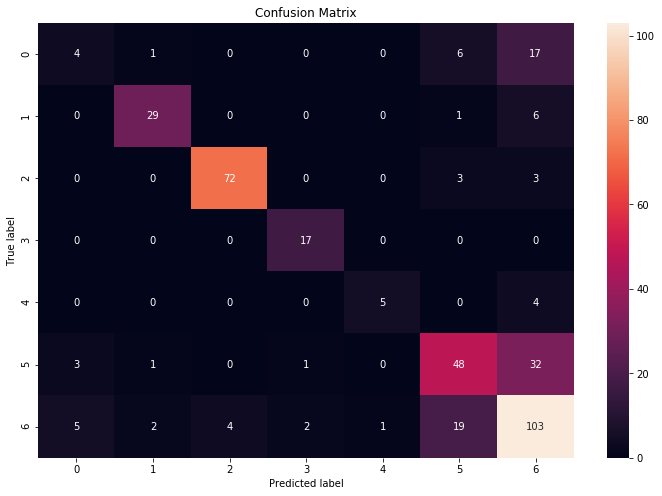

0.714652956298
              precision    recall  f1-score   support

           0       0.14      0.33      0.20        12
           1       0.81      0.88      0.84        33
           2       0.92      0.95      0.94        76
           3       1.00      0.85      0.92        20
           4       0.56      0.83      0.67         6
           5       0.56      0.62      0.59        77
           6       0.76      0.62      0.68       165

   micro avg       0.71      0.71      0.71       389
   macro avg       0.68      0.73      0.69       389
weighted avg       0.75      0.71      0.73       389



In [16]:
clf=RandomForestClassifier(random_state=17, min_samples_split=2, n_estimators=55)
clf.fit(X_train_pca, labels_train)
y_pred=clf.predict(X_test_pca)
cm = confusion_matrix(labels_test, y_pred)
draw_confusion_matrix(cm)
print(accuracy_score(y_pred, labels_test))
print(classification_report(y_pred, labels_test))

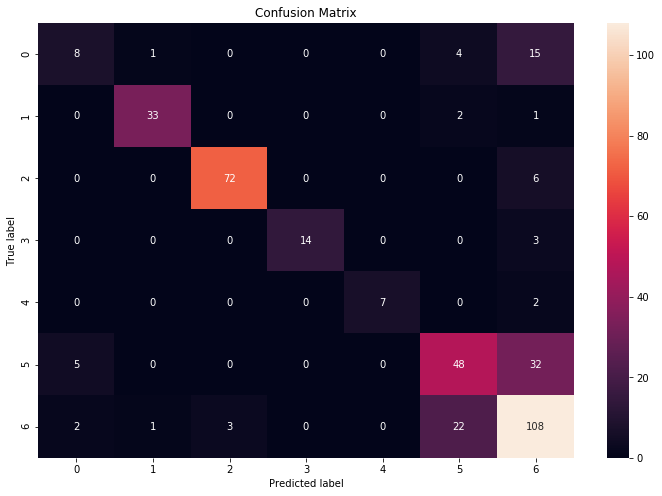

0.745501285347
              precision    recall  f1-score   support

           0       0.29      0.53      0.37        15
           1       0.92      0.94      0.93        35
           2       0.92      0.96      0.94        75
           3       0.82      1.00      0.90        14
           4       0.78      1.00      0.88         7
           5       0.56      0.63      0.60        76
           6       0.79      0.65      0.71       167

   micro avg       0.75      0.75      0.75       389
   macro avg       0.73      0.82      0.76       389
weighted avg       0.77      0.75      0.75       389



In [22]:
clf=RandomForestClassifier(random_state=17, min_samples_split=2, n_estimators=55)
clf.fit(X_train, labels_train)
y_pred=clf.predict(X_test)
cm = confusion_matrix(labels_test, y_pred)
draw_confusion_matrix(cm)
print(accuracy_score(y_pred, labels_test))
print(classification_report(y_pred, labels_test))

/home/gazizullina149/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


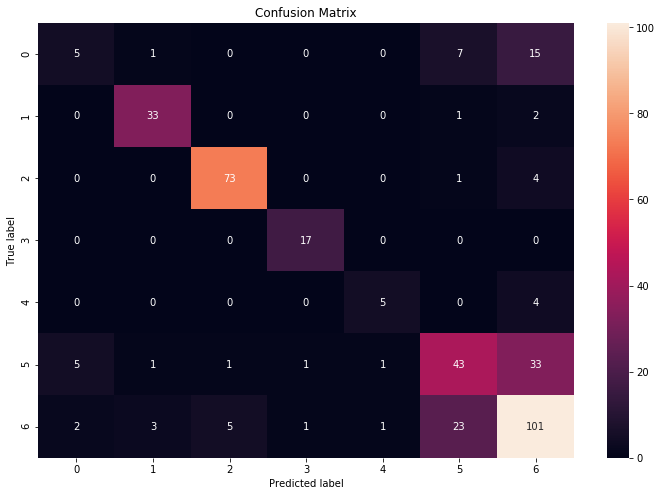

0.712082262211
              precision    recall  f1-score   support

           0       0.18      0.42      0.25        12
           1       0.92      0.87      0.89        38
           2       0.94      0.92      0.93        79
           3       1.00      0.89      0.94        19
           4       0.56      0.71      0.63         7
           5       0.51      0.57      0.54        75
           6       0.74      0.64      0.68       159

   micro avg       0.71      0.71      0.71       389
   macro avg       0.69      0.72      0.69       389
weighted avg       0.75      0.71      0.72       389



In [23]:
clf=SVC()
clf.fit(X_train_pca, labels_train)
y_pred=clf.predict(X_test_pca)
cm = confusion_matrix(labels_test, y_pred)
draw_confusion_matrix(cm)
print(accuracy_score(y_pred, labels_test))
print(classification_report(y_pred, labels_test))

## Use cross validation

### 1. Random Forests

#### (a) Simple features

[train]: acc - 1.0, f1-score - 1.0
[val]: acc - 0.7464149110557949, f1-score - 0.7487428118325589


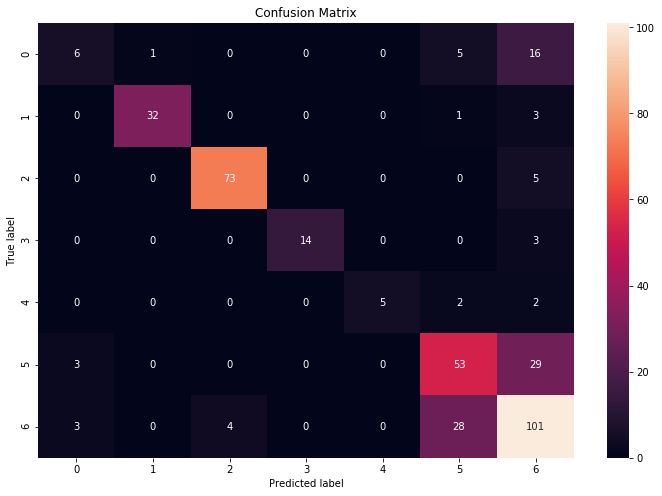

[Test] acc - 0.7300771208226221
              precision    recall  f1-score   support

           0       0.21      0.50      0.30        12
           1       0.89      0.97      0.93        33
           2       0.94      0.95      0.94        77
           3       0.82      1.00      0.90        14
           4       0.56      1.00      0.71         5
           5       0.62      0.60      0.61        89
           6       0.74      0.64      0.68       159

   micro avg       0.73      0.73      0.73       389
   macro avg       0.68      0.81      0.73       389
weighted avg       0.75      0.73      0.74       389



In [239]:
clf=RandomForestClassifier(random_state=17, min_samples_split=2, n_estimators=300)
cv(X_train, X_test, labels_train, labels_test, clf)

[train]: acc - 1.0, f1-score - 1.0
[val]: acc - 0.7585635359116022, f1-score - 0.76215686200136


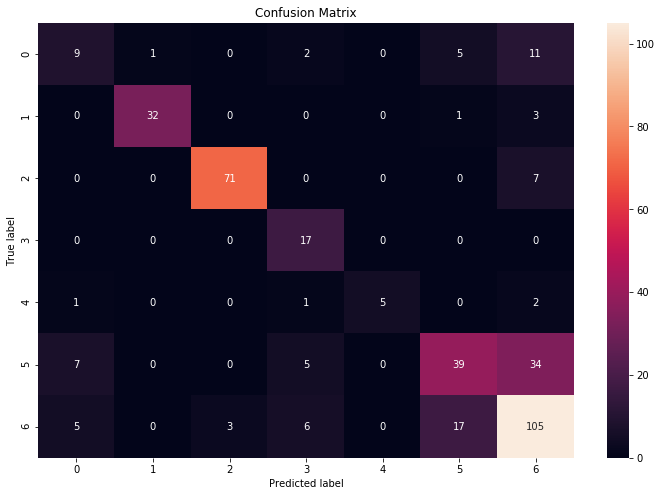

[Test] acc - 0.7146529562982005
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        22
           1       0.89      0.97      0.93        33
           2       0.91      0.96      0.93        74
           3       1.00      0.55      0.71        31
           4       0.56      1.00      0.71         5
           5       0.46      0.63      0.53        62
           6       0.77      0.65      0.70       162

   micro avg       0.71      0.71      0.71       389
   macro avg       0.70      0.74      0.70       389
weighted avg       0.75      0.71      0.72       389



In [121]:
clf=RandomForestClassifier(random_state=17, min_samples_split=2, n_estimators=10000)
cv(X_train, X_test, labels_train, labels_test, clf)

#### (b) recursive feature elimination

[train]: acc - 0.9875960862543934, f1-score - 0.9876354064748304
[val]: acc - 0.7442292514115718, f1-score - 0.7475089033666377


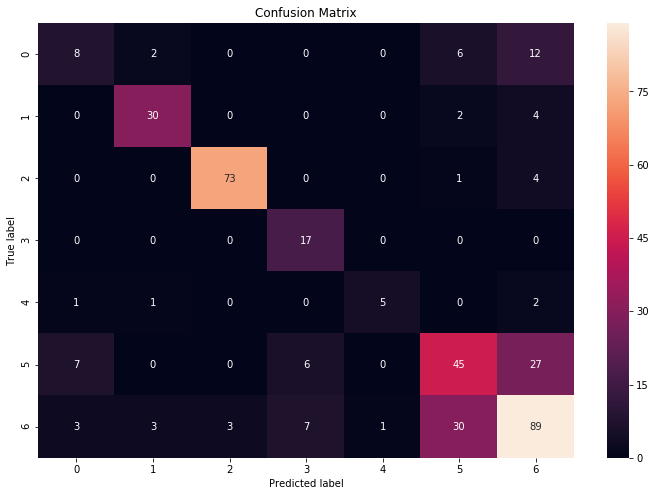

[Test] acc - 0.6863753213367609
              precision    recall  f1-score   support

           0       0.29      0.42      0.34        19
           1       0.83      0.83      0.83        36
           2       0.94      0.96      0.95        76
           3       1.00      0.57      0.72        30
           4       0.56      0.83      0.67         6
           5       0.53      0.54      0.53        84
           6       0.65      0.64      0.65       138

   micro avg       0.69      0.69      0.69       389
   macro avg       0.68      0.69      0.67       389
weighted avg       0.71      0.69      0.69       389



In [122]:
clf=RandomForestClassifier(random_state=17, n_estimators=10000, min_samples_leaf=2)
cv(X_train_rfe, X_test_rfe, labels_train, labels_test, clf)

#### (c) + DBSCAN features

[train]: acc - 0.9936608720433172, f1-score - 0.9936861290687998
[val]: acc - 0.7320745552789752, f1-score - 0.7393168997578577


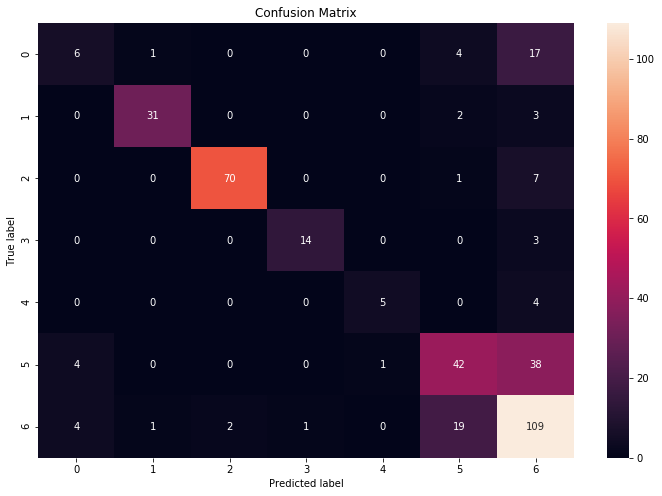

[Test] acc - 0.712082262210797
              precision    recall  f1-score   support

           0       0.21      0.43      0.29        14
           1       0.86      0.94      0.90        33
           2       0.90      0.97      0.93        72
           3       0.82      0.93      0.87        15
           4       0.56      0.83      0.67         6
           5       0.49      0.62      0.55        68
           6       0.80      0.60      0.69       181

   micro avg       0.71      0.71      0.71       389
   macro avg       0.66      0.76      0.70       389
weighted avg       0.75      0.71      0.72       389



In [123]:
clf=RandomForestClassifier(random_state=17, n_estimators=1000, min_samples_leaf=2)
cv(X_train_dbscan, X_test_dbscan, labels_train, labels_test, clf)

[train]: acc - 0.9933861499002565, f1-score - 0.9934092444711968
[val]: acc - 0.7232712039341874, f1-score - 0.728981306196944


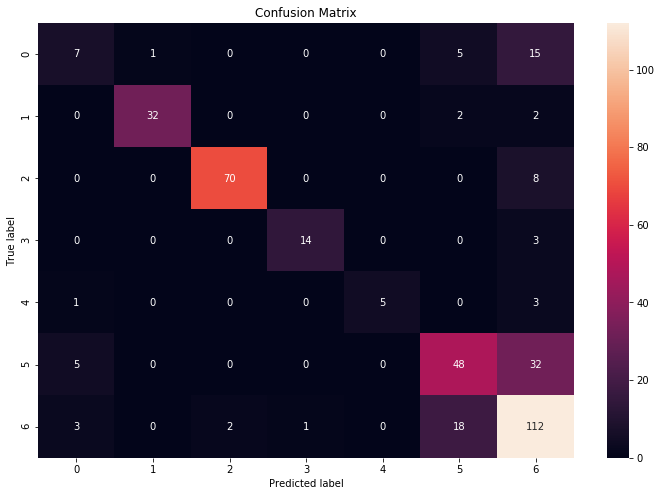

[Test] acc - 0.7403598971722365
              precision    recall  f1-score   support

           0       0.25      0.44      0.32        16
           1       0.89      0.97      0.93        33
           2       0.90      0.97      0.93        72
           3       0.82      0.93      0.87        15
           4       0.56      1.00      0.71         5
           5       0.56      0.66      0.61        73
           6       0.82      0.64      0.72       175

   micro avg       0.74      0.74      0.74       389
   macro avg       0.69      0.80      0.73       389
weighted avg       0.77      0.74      0.75       389



In [112]:
clf=RandomForestClassifier(random_state=17, n_estimators=10000, min_samples_leaf=2)
cv(X_train_dbscan, X_test_dbscan, labels_train, labels_test, clf)

### 2. Lightgbm

In [8]:
X_train_lgb = lgb.Dataset(X_train, label=labels_train)
X_test_lgb = lgb.Dataset(X_test, label=labels_test)

X_train_rfe_lgb = lgb.Dataset(X_train_rfe, label=labels_train)
X_test_rfe_lgb = lgb.Dataset(X_test_rfe, label=labels_test)

X_train_dbscan_lgb = lgb.Dataset(X_train_dbscan, label=labels_train)
X_test_dbscan_lgb = lgb.Dataset(X_test_dbscan, label=labels_test)

In [217]:
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['max_bin'] = 10
params['sub_feature'] = 0.5
params['num_leaves'] = 7
params['min_data'] = 20
params['max_depth'] = 10
params['num_class'] = 7
params['lambda_l2'] = 3
params['lambda_l1'] = 0.1
params['feature_fraction'] = 0.7
params['bagging_fraction'] = 0.85

In [218]:
lgb_1 = lgb.train(params, X_train_lgb, 1000)

In [219]:
y_pred=lgb_1.predict(X_test)

In [220]:
y_pred = [np.argmax(row) for row in y_pred]

In [221]:
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred, labels_test, average='weighted'), accuracy_score(y_pred, labels_test)))

f1-score - 0.7583597870268051, accuracy - 0.7506426735218509


In [222]:
cv_results = lgb.cv(
        params,
        X_train_lgb,
        num_boost_round=10000,
        nfold=5,
        early_stopping_rounds=10,
        verbose_eval= 100
        )

[100]	cv_agg's multi_logloss: 1.05714 + 0.0174739
[200]	cv_agg's multi_logloss: 0.836713 + 0.0219604
[300]	cv_agg's multi_logloss: 0.729481 + 0.0258586
[400]	cv_agg's multi_logloss: 0.669565 + 0.0312115
[500]	cv_agg's multi_logloss: 0.634302 + 0.0359748
[600]	cv_agg's multi_logloss: 0.614075 + 0.0378278
[700]	cv_agg's multi_logloss: 0.601983 + 0.0393249
[800]	cv_agg's multi_logloss: 0.593365 + 0.0402074
[900]	cv_agg's multi_logloss: 0.587908 + 0.0413215
[1000]	cv_agg's multi_logloss: 0.584127 + 0.0420029
[1100]	cv_agg's multi_logloss: 0.581372 + 0.0432117


In [184]:
print('Best CV score:', cv_results['multi_logloss-mean'][-1])

Best CV score: 0.60656830128


#### dbscan features

In [442]:
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['max_bin'] = 10
params['sub_feature'] = 0.5
params['num_leaves'] = 7
params['min_data'] = 20
params['max_depth'] = 10
params['num_class'] = 7
params['lambda_l2'] = 7
params['lambda_l1'] = 0.1
params['feature_fraction'] = 0.7
params['bagging_fraction'] = 0.85

In [443]:
cv_results = lgb.cv(
        params,
        X_train_dbscan_lgb,
        num_boost_round=10000,
        nfold=5,
        early_stopping_rounds=100,
        verbose_eval= 100
        )

[100]	cv_agg's multi_logloss: 0.79376 + 0.0240141
[200]	cv_agg's multi_logloss: 0.67417 + 0.0331727
[300]	cv_agg's multi_logloss: 0.635987 + 0.0353917
[400]	cv_agg's multi_logloss: 0.618033 + 0.0376342
[500]	cv_agg's multi_logloss: 0.61166 + 0.0387044
[600]	cv_agg's multi_logloss: 0.611695 + 0.0410846


In [391]:
lgb_2 = lgb.train(params, X_train_dbscan_lgb, 10000)
y_pred=lgb_2.predict(X_test_dbscan_lgb)
y_pred = [np.argmax(row) for row in y_pred]
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred, labels_test, average='weighted'), accuracy_score(y_pred, labels_test)))

f1-score - 0.7682823150425176, accuracy - 0.7634961439588689


### 3. KNN

In [393]:
from sklearn.neighbors import KNeighborsClassifier  

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [397]:
y_pred = classifier.predict(X_test)  
y_pred = [np.argmax(row) for row in y_pred]
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred, labels_test, average='weighted'), accuracy_score(y_pred, labels_test)))

f1-score - 0.6930100462151847, accuracy - 0.699228791773779


#### (a) Select the number of neighbours

In [423]:
error = []
best_err = 100
best_k = 0
y_pred_best = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    err_mean = np.mean(pred_i != y_test)
    if err_mean<best_err:
        y_pred_best = pred_i
        best_err = err_mean
        best_k = i
    error.append(err_mean)
    
y_pred_best = [np.argmax(row) for row in y_pred_best]
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred_best, labels_test, average='weighted'), accuracy_score(y_pred_best, labels_test)))

f1-score - 0.5310194726397856, accuracy - 0.5732647814910026


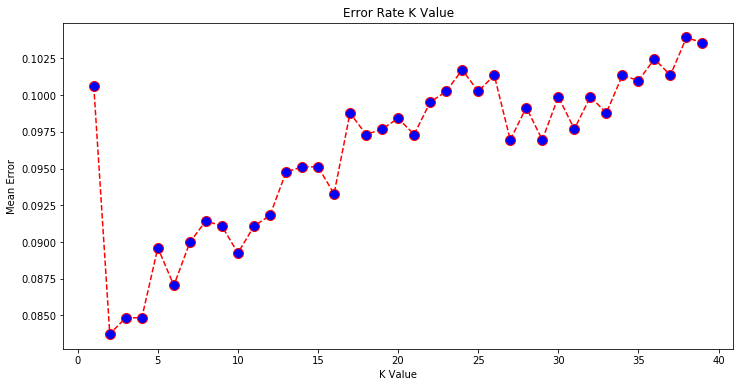

In [424]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [425]:
print("best k - {}, best error - {}".format(best_k, best_err))

best k - 2, best error - 0.08373117884686009


Here we can see that the optimal value of k here is 3 and 8

#### (b) Use dbscan features

best k - 3, best error - 0.07051046639735586
f1-score - 0.7374690945582582, accuracy - 0.7377892030848329


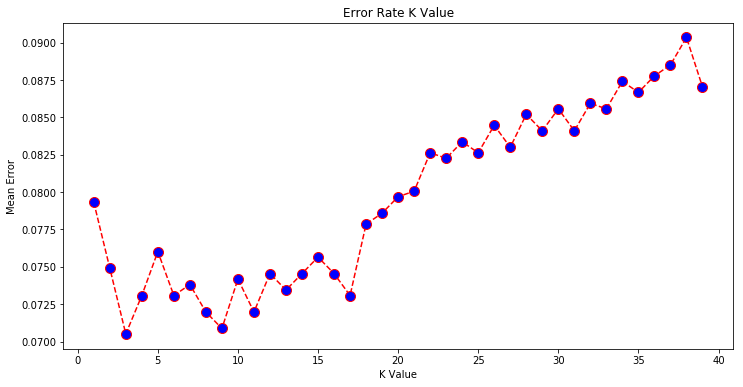

In [446]:
sc = StandardScaler()
X_train = X_train_dbscan
X_test = X_test_dbscan
X_train[:, :27] = sc.fit_transform(X_train[:, :27])
X_test[:, :27] = sc.transform(X_test[:, :27])
best_err = 100
best_k = 0
y_pred_best = []
knn_best = None
error = []
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    err_mean = np.mean(pred_i != y_test)
    if err_mean<best_err:
        knn_best = knn
        y_pred_best = pred_i
        best_err = err_mean
        best_k = i
    error.append(err_mean)
    
y_pred_best = [np.argmax(row) for row in y_pred_best]
print("best k - {}, best error - {}".format(best_k, best_err))
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred_best, labels_test, average='weighted'), accuracy_score(y_pred_best, labels_test)))

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

#### (d) RFE features

best k - 2, best error - 0.08373117884686009
f1-score - 0.5310194726397856, accuracy - 0.5732647814910026


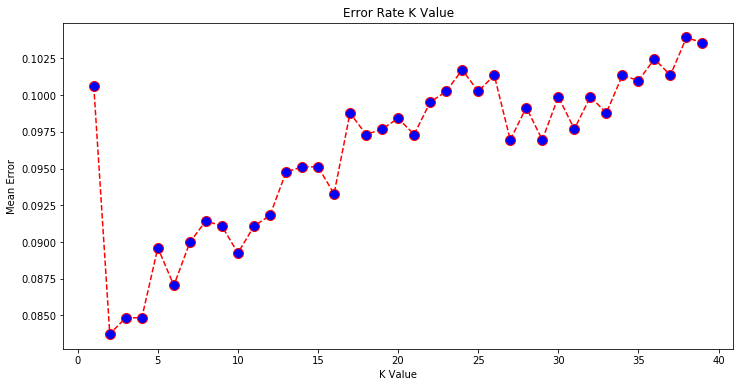

In [427]:
sc = StandardScaler()
X_train = X_train_rfe
X_test = X_test_rfe
X_train[:, :27] = sc.fit_transform(X_train[:, :27])
X_test[:, :27] = sc.transform(X_test[:, :27])
best_err = 100
best_k = 0
y_pred_best = []

error = []
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    err_mean = np.mean(pred_i != y_test)
    if err_mean<best_err:
        y_pred_best = pred_i
        best_err = err_mean
        best_k = i
    error.append(err_mean)

y_pred_best = [np.argmax(row) for row in y_pred_best]
print("best k - {}, best error - {}".format(best_k, best_err))
print("f1-score - {}, accuracy - {}".format(f1_score(y_pred_best, labels_test, average='weighted'), accuracy_score(y_pred_best, labels_test)))

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

### Predict

In [448]:
y_pred_test = lgb_2.predict(test_dbscan)

test_arr = test_dbscan
sc = StandardScaler()
X_train = X_train_dbscan
X_test = X_test_dbscan
X_train[:, :27] = sc.fit_transform(X_train[:, :27])
test_arr[:, :27] = sc.transform(test_arr[:, :27])

y_pred_knn_test = knn_best.predict(test_arr)

In [449]:
labels_pred = [np.argmax(row) for row in y_pred_test]
labels_pred_knn = [np.argmax(row) for row in y_pred_knn_test]

In [450]:
from numpy import argmax
from keras.utils import to_categorical
labels_pred = np.array(labels_pred)
# one hot encode
encoded = to_categorical(labels_pred)

labels_pred_knn = np.array(labels_pred_knn)
# one hot encode
encoded_knn = to_categorical(labels_pred_knn)

In [451]:
np.save("pred.npy", encoded)
np.save("pred.npy", encoded_knn)

In [452]:
np.load("pred.npy")

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [ ]:
np.load("pred_knn.npy")